In [1]:
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
import sys
sys.path.append('../')
import os
from pathlib import Path

In [2]:
data_folder = Path(r"C:\Users\Guillaume\Documents\data")
data_all = []

filters = ['tif','tiff']

files = os.listdir(data_folder)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} because not in filters")
        files.remove(f)
        continue

    im = imread(data_folder / f)
    data_all.append(im)
    print(f"{f}:\t shape: {im.shape}")

print(f"\nFound {len(files)} files.")

data_all = np.stack(data_all)

print(f"\nAll data loaded in numpy array `data_all`, of shape: {data_all.shape}, corresponding to: (#files,#frames,H,W)")

rec_c01_rec_CAM.tiff:	 shape: (6, 1416, 1392)
rec_c02_rec_CAM.tiff:	 shape: (6, 1416, 1392)
rec_c03_rec_CAM.tiff:	 shape: (6, 1416, 1392)

Found 3 files.

All data loaded in numpy array `data_all`, of shape: (3, 6, 1416, 1392), corresponding to: (#files,#frames,H,W)


In [3]:
# In this dataset everything is low, high followed by bleaching, so:
frame_low = 0
frame_high = 1

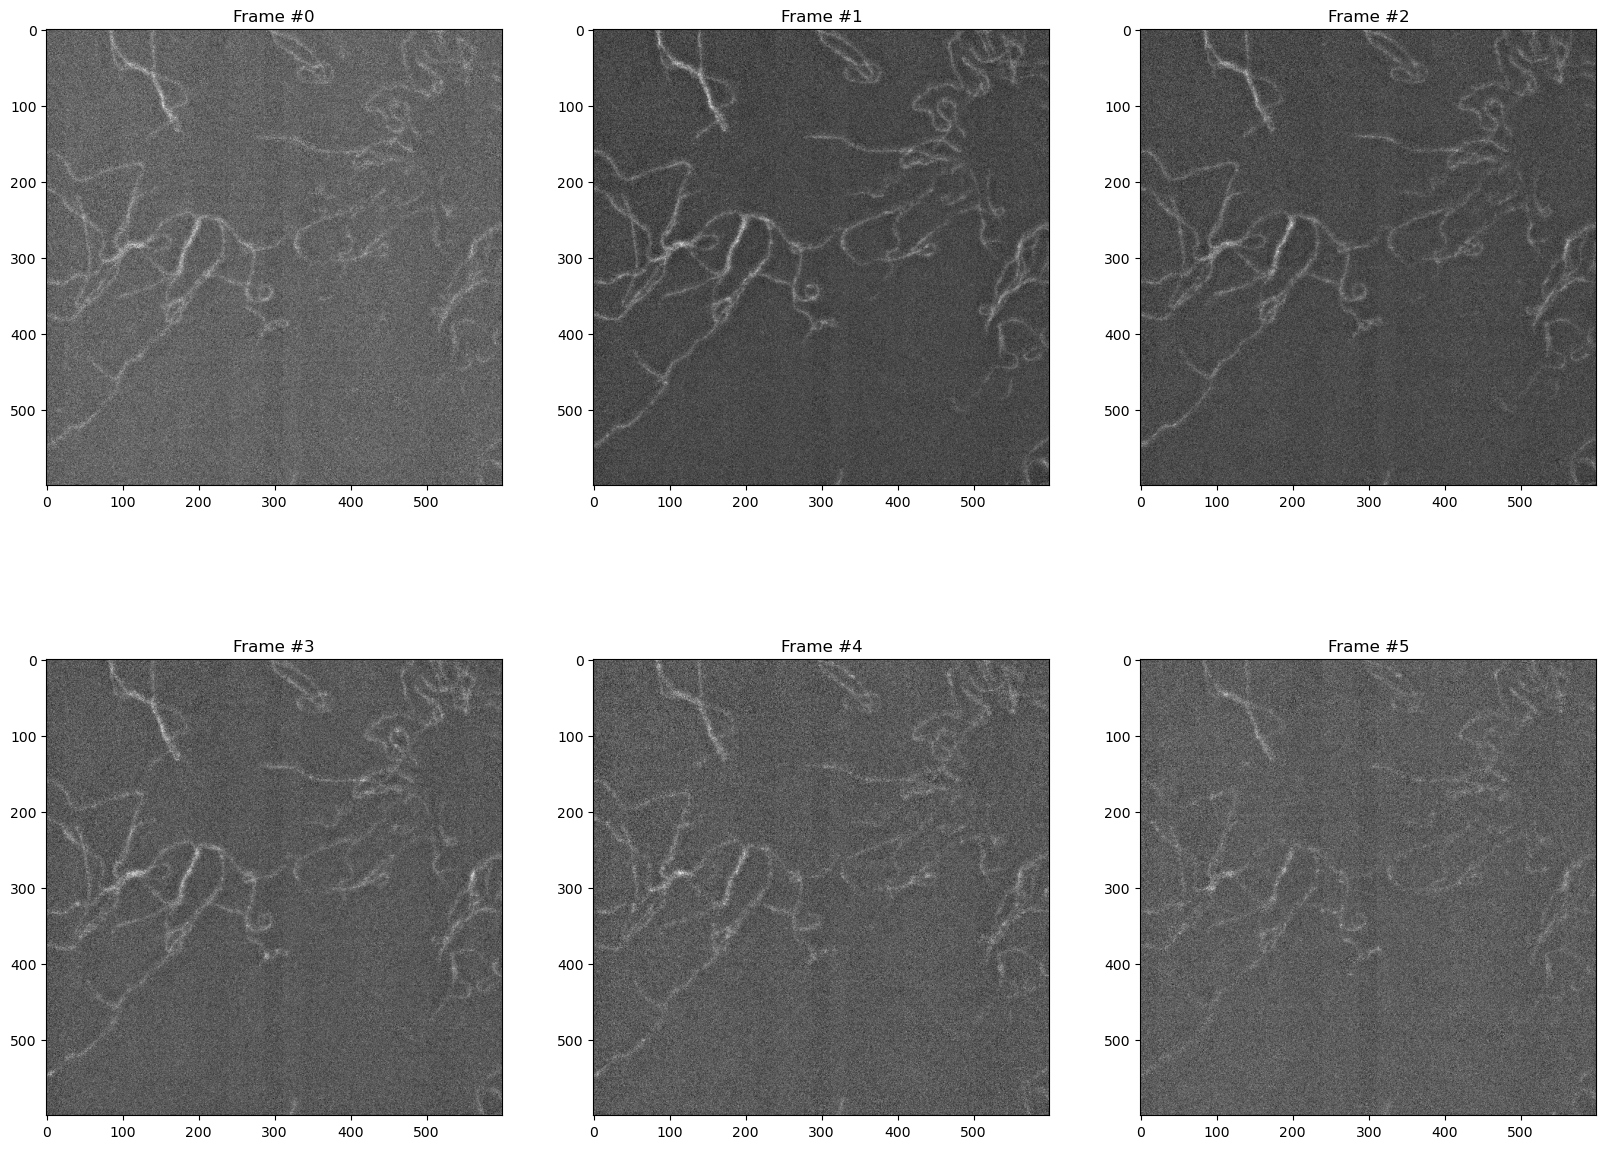

In [4]:
# Display all SNRs for one image (centered crop with crop_size)

file_idx = 0
crop_size = 600
figure_size = (20,15)

# load image
im = data_all[file_idx]

# crop image
starty,startx = im.shape[1]//2-crop_size//2, im.shape[2]//2-crop_size//2
stopy,stopx = im.shape[1]//2+crop_size//2,im.shape[2]//2+crop_size//2
# print(starty,startx,stopy,stopx)
im_crop = im[:,starty:stopy,starty:stopy]

# calculate subplot parameters
n = im_crop.shape[0]
subplot_x = math.floor(math.sqrt(n))
subplot_y = math.ceil(n / subplot_x)

# plot cropped frames
plt.figure(figsize=figure_size)
for i in range(n):
    plt.subplot(subplot_x,subplot_y,i+1)
    plt.imshow(im_crop[i],cmap='gray')
    plt.title(f'Frame #{i}')

In [5]:
# Calculate cumulative avg 

n = data_all.shape[1] - 2
cumul_avg = []
for i in range (frame_high,n):
    cumul_avg.append(np.mean(data_all[:,frame_high:i+2],axis = 1))

cumul_avg = np.transpose(np.stack(cumul_avg),(1,0,2,3))

print(f"Cumul_avg  shape in (file, avg, H,W ): {cumul_avg.shape}")


Cumul_avg  shape in (file, avg, H,W ): (3, 3, 1416, 1392)


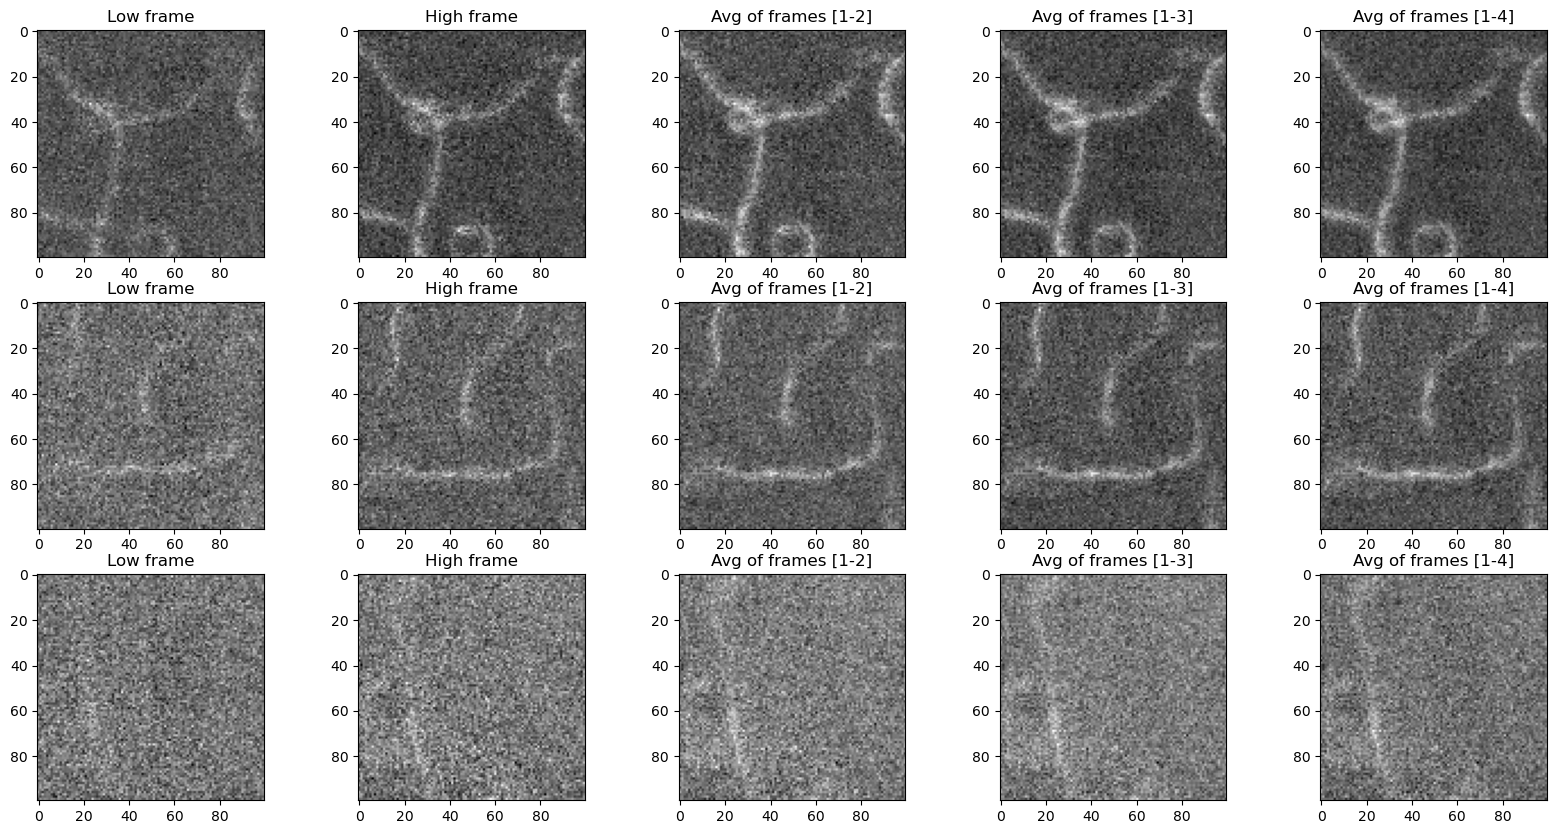

In [6]:
# display cumulative avg for X images (center cropped) + low and high for comparison

n_images_display = 3 #should not ne greater than #files
crop_size = 100

# plot parameters
figure_size = (20,10)
subplot_x = n_images_display
subplot_y = cumul_avg.shape[1] + 2 #number of avg + low + high

# crop
starty,startx = data_all.shape[2]//2-crop_size//2, data_all.shape[3]//2-crop_size//2
stopy,stopx = data_all.shape[2]//2+crop_size//2,data_all.shape[3]//2+crop_size//2
cumul_avg_crop = cumul_avg[:,:,starty:stopy,startx:stopx]
high_frame_cropped = data_all[:,frame_high,starty:stopy,startx:stopx]
low_frame_cropped = data_all[:,frame_low,starty:stopy,startx:stopx]

# plot
plt.figure(figsize=figure_size)
subplotidx = 1
for i in range(n_images_display):
    # low frame
    plt.subplot(subplot_x,subplot_y,subplotidx)
    plt.imshow(low_frame_cropped[i],cmap='gray')
    plt.title(f'Low frame')
    subplotidx += 1
    # high frame
    plt.subplot(subplot_x,subplot_y,subplotidx)
    plt.imshow(high_frame_cropped[i],cmap='gray')
    plt.title(f'High frame')
    subplotidx += 1
    for j in range (cumul_avg.shape[1]):
        plt.subplot(subplot_x,subplot_y,subplotidx)
        plt.imshow(cumul_avg_crop[i,j],cmap='gray')
        plt.title(f'Avg of frames [{frame_high}-{j+1+frame_high}]')
        subplotidx += 1

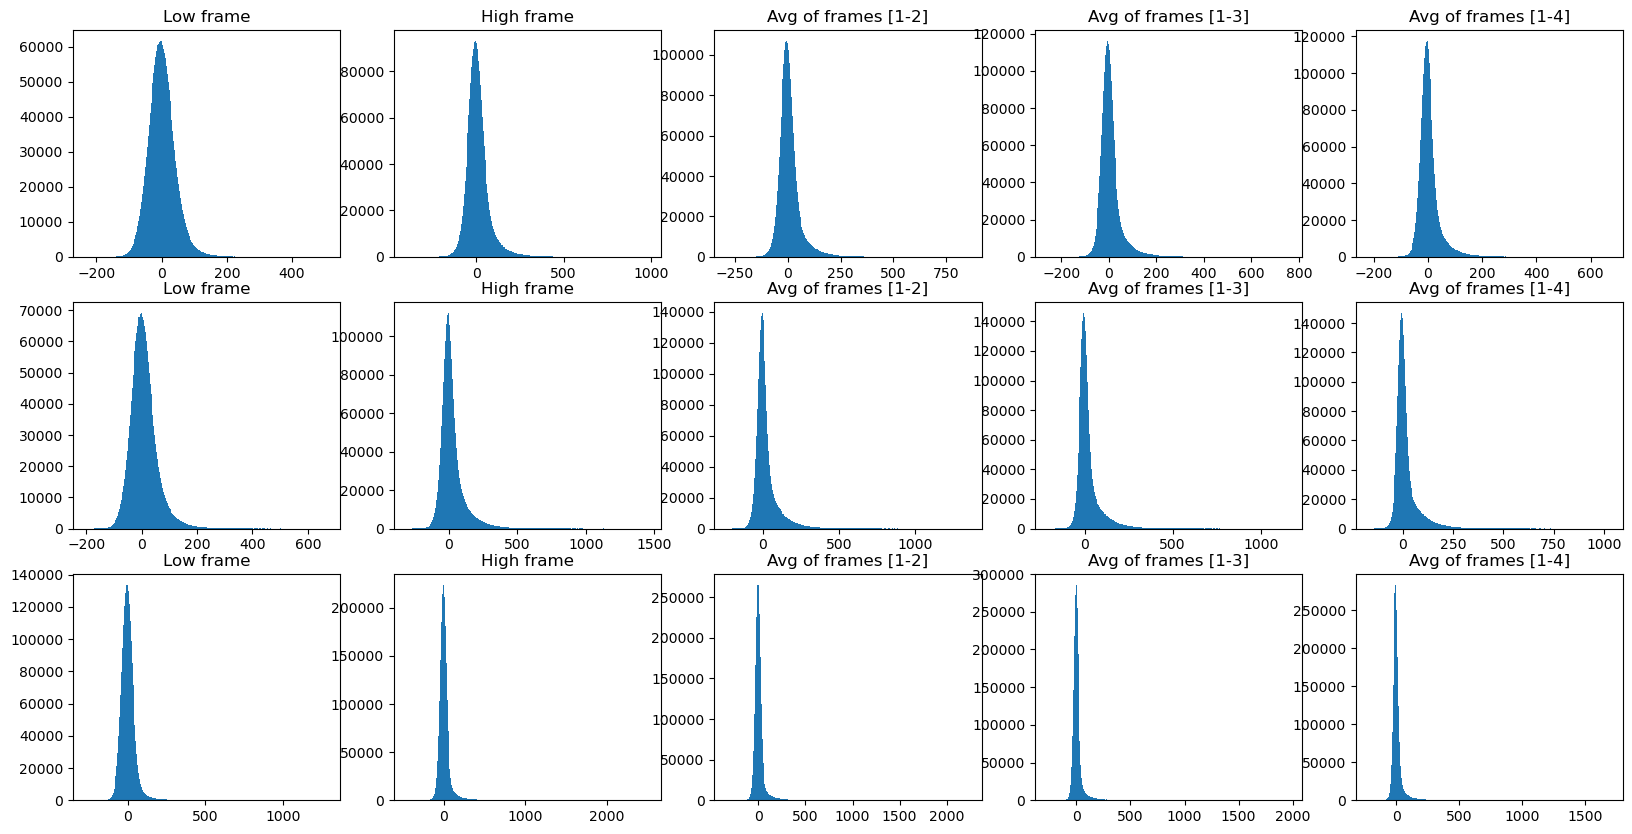

In [7]:
# Display histogram of:
#   - low frame
#   - high frame
#   - cumulative avg 
# => for X images (not cropped)

n_images_display = 3 #should not ne greater than #files

# plot parameters
figure_size = (20,10)
subplot_x = n_images_display
subplot_y = cumul_avg.shape[1] + 2 #number of avg + initial frame

# crop
starty,startx = data_all.shape[2]//2-crop_size//2, data_all.shape[3]//2-crop_size//2
stopy,stopx = data_all.shape[2]//2+crop_size//2,data_all.shape[3]//2+crop_size//2

# plot separately
plt.figure(figsize=figure_size)
subplotidx = 1
for i in range(n_images_display):
    # Low Frame
    plt.subplot(subplot_x,subplot_y,subplotidx)
    plt.hist(data_all[i,frame_low].flatten(),bins=256)
    plt.title(f'Low frame')
    subplotidx += 1
    # High Frame
    plt.subplot(subplot_x,subplot_y,subplotidx)
    plt.hist(data_all[i,frame_high].flatten(),bins=256)
    plt.title(f'High frame')
    subplotidx += 1
    for j in range (cumul_avg.shape[1]):
        plt.subplot(subplot_x,subplot_y,subplotidx)
        plt.hist(cumul_avg[i,j].flatten(),bins=256)
        plt.title(f'Avg of frames [{frame_high}-{j+1+frame_high}]')
        subplotidx += 1
        


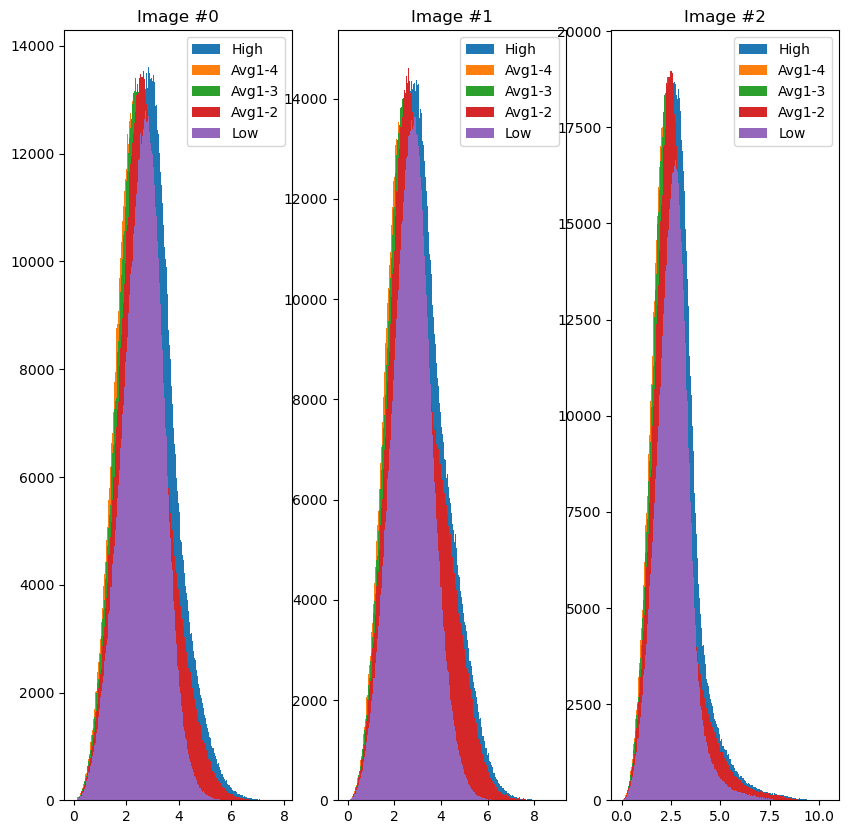

In [10]:
# overlay hist of high,low,and avgs (pwr = 0.5 or lower helps visualization)
pwr = 0.3
plt.figure(figsize=(10,10))
for i in range(n_images_display):
    plt.subplot(1,n_images_display,i+1)
    plt.hist((data_all[i,frame_high].flatten())**pwr,bins=256,label='High')
    plt.hist((cumul_avg[i,-1].flatten())**pwr,bins=256,label=f'Avg1-4')
    plt.hist((cumul_avg[i,-2].flatten())**pwr,bins=256,label=f'Avg1-3')
    plt.hist((cumul_avg[i,-3].flatten())**pwr,bins=256,label=f'Avg1-2')
    plt.hist((data_all[i,frame_low].flatten())**pwr,bins=256,label='Low')
    plt.legend()
    plt.title(f"Image #{i}")

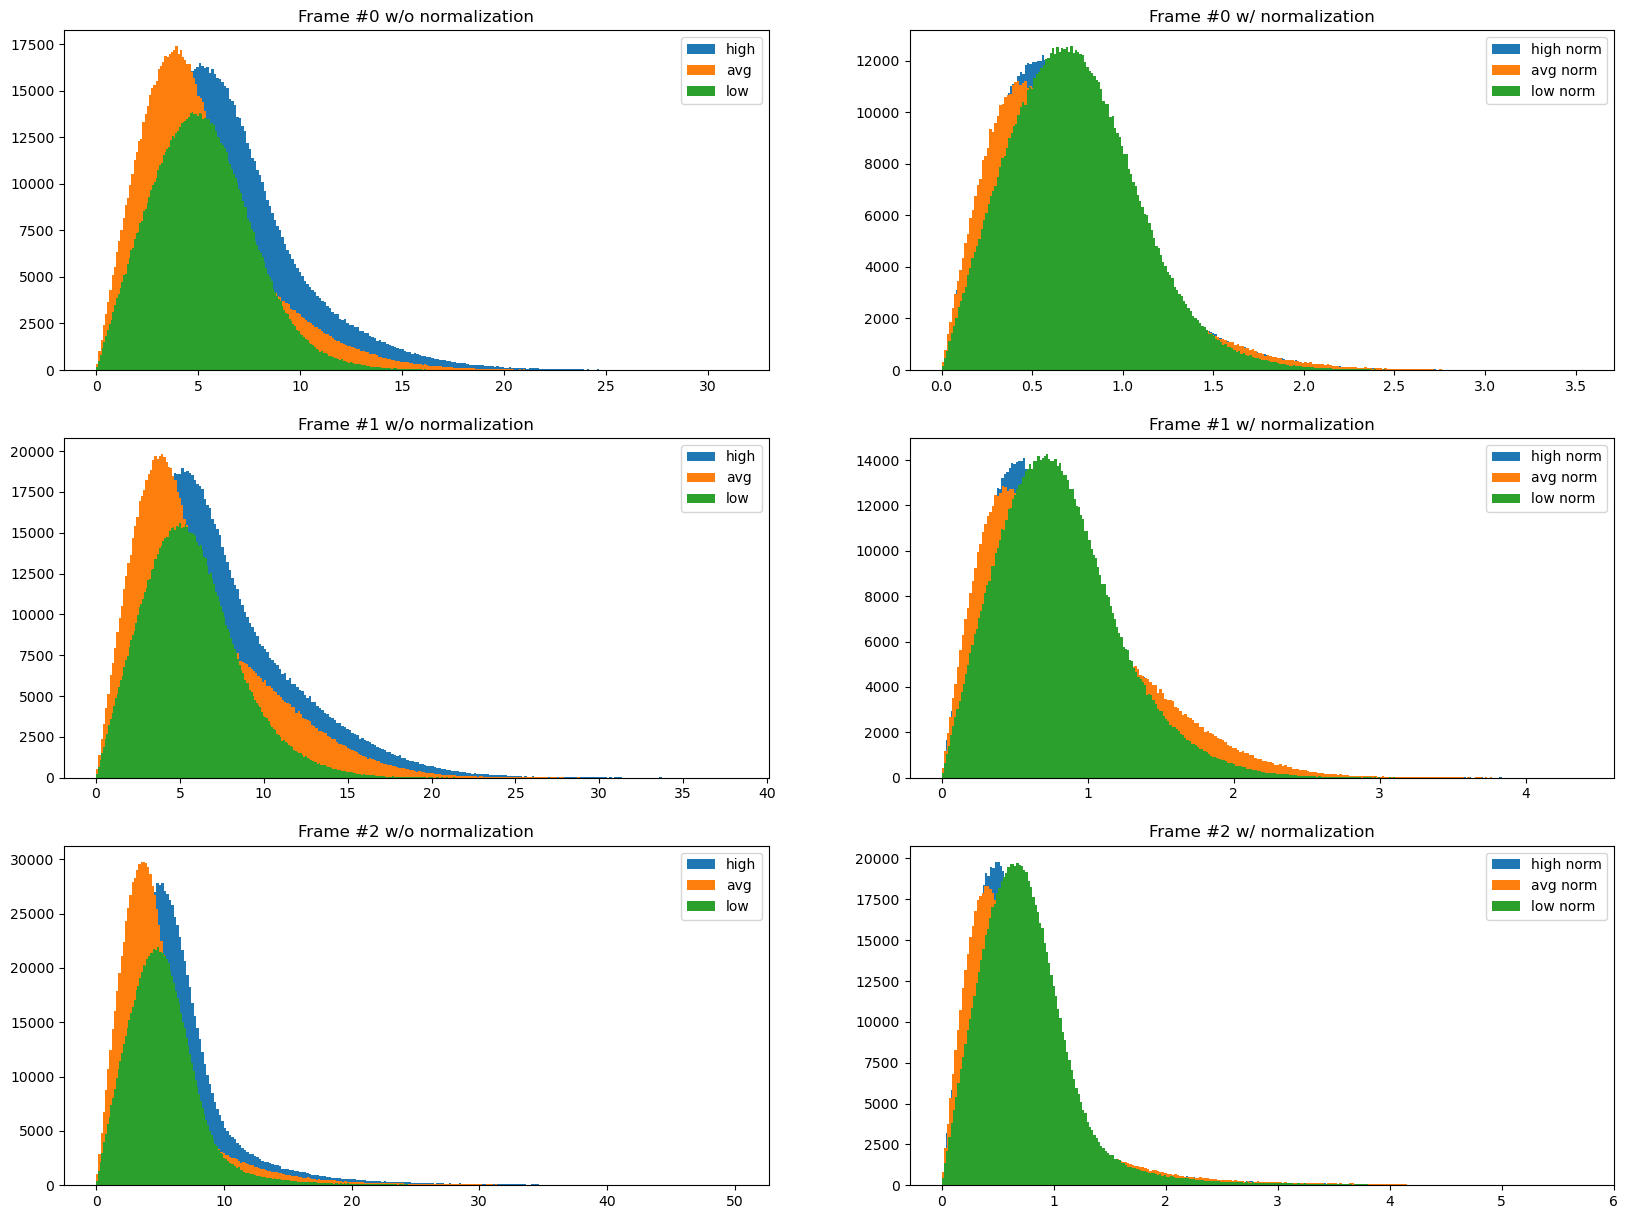

In [9]:
# Normalizing and checking historgam impacts

n_images_display = 3
figure_size = (20,15)
pwr = 0.5 # < 1 helps visualization

highs = data_all[:,1]
lows = data_all[:,0]
avgs = cumul_avg[:,-2]

highs_norm = (highs - np.mean(highs))/np.std(highs)
lows_norm = (lows - np.mean(lows))/np.std(lows)
avgs_norm = (avgs - np.mean(avgs))/np.std(avgs)

plt.figure(figsize=figure_size)
subplotidx = 1
for i in range(n_images_display):
    # display w/o norm
    plt.subplot(n_images_display,2,subplotidx)
    plt.hist((highs[i].flatten())**pwr,bins=256,label="high")
    plt.hist((avgs[i].flatten())**pwr,bins=256,label="avg")
    plt.hist((lows[i].flatten())**pwr,bins=256,label="low")
    plt.legend()
    plt.title(f"Frame #{i} w/o normalization")
    subplotidx +=1

    # display w norm
    plt.subplot(n_images_display,2,subplotidx)
    plt.hist((highs_norm[i].flatten())**pwr,bins=256,label="high norm")
    plt.hist((avgs_norm[i].flatten())**pwr,bins=256,label="avg norm")
    plt.hist((lows_norm[i].flatten())**pwr,bins=256,label="low norm")
    plt.legend()
    plt.title(f"Frame #{i} w/ normalization")
    subplotidx +=1